In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('./src')

import os
os.environ['JAX_PLATFORMS']="cpu"

In [3]:
import diffusion

In [4]:
from diffusion import sde
import jax 
from jax import jit, grad, vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from tqdm.auto import tqdm

from diffrax import Euler

import seaborn as sns
sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)

solver = Euler()

In [5]:
def sample_sphere(J):
    """
    2 dimensional sample

    N_samples: Number of samples
    Returns a (N_samples, 2) array of samples
    """
    alphas = jnp.linspace(0, 2*jnp.pi * (1 - 1/J), J)
    xs = jnp.cos(alphas)
    ys = jnp.sin(alphas)
    mf = jnp.stack([xs, ys], axis=1)
    return mf

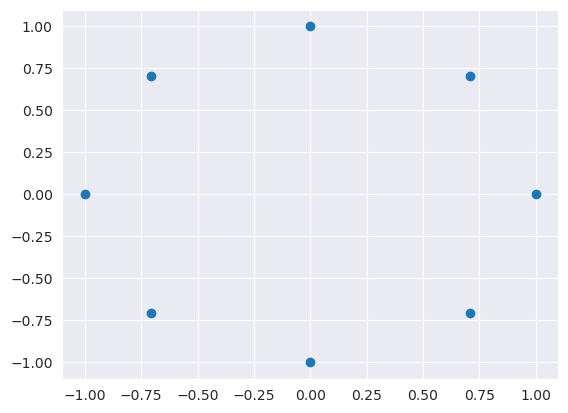

In [6]:
J = 8
mf = sample_sphere(J)
plt.scatter(mf[:, 0], mf[:, 1])
plt.show()

In [7]:
vp = sde.VPSDE(2)

In [8]:
from jax.scipy.special import logsumexp

# compute explicitly the score of the dataset
def log_hat_pt(x, t):
    """
    x: One location in R^n
    t: time (number)
    returns the log density log \hat{p}_t(x) as described above

    """
    N = mf.shape[0]
    means = mf * vp.mean_coeff(t)
    v = vp.variance(t)
    potentials = jnp.sum(-(x - means)**2 / (2 * v), axis=1)
    # this is equivalent to
    # return jnp.log(1/N * jnp.sum(jnp.exp(potentials)))
    # but is numerically more stable
    return logsumexp(potentials, axis=0, b=1/N)

score = jit(grad(log_hat_pt))
nabla_log_hat_pt = jit(vmap(grad(log_hat_pt), in_axes=(0, 0), out_axes=(0)))

<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
/tmp/aamerio/ipykernel_132683/837006377.py:5: SyntaxWarning: invalid escape sequence '\h'
  """


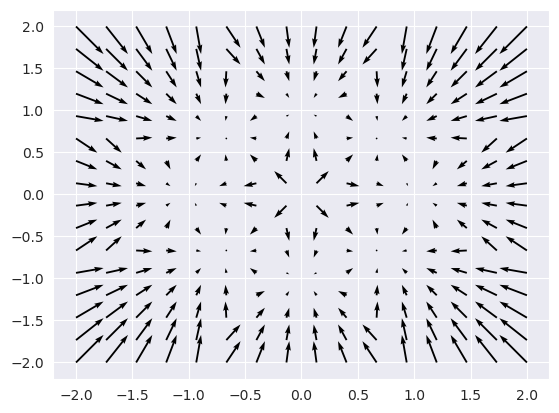

In [9]:
def plot_score(score, t, area_min=-1, area_max=1):
    #this helper function is here so that we can jit it.
    #We can not jit the whole function since plt.quiver cannot
    #be jitted
    @partial(jit, static_argnums=[0,])
    def helper(score, t, area_min, area_max):
        x = jnp.linspace(area_min, area_max, 16)
        x, y = jnp.meshgrid(x, x)
        grid = jnp.stack([x.flatten(), y.flatten()], axis=1)
        t = jnp.ones((grid.shape[0], 1)) * t
        scores = score(grid, t)
        return grid, scores
    grid, scores = helper(score, t, area_min, area_max)
    plt.quiver(grid[:, 0], grid[:, 1], scores[:, 0], scores[:, 1])

plot_score(nabla_log_hat_pt, 0.001, -2, 2)

In [10]:
def plot_heatmap(positions, area_min=-2, area_max=2):
    """
    positions: locations of all particles in R^2, array (J, 2)
    area_min: lowest x and y coordinate
    area_max: highest x and y coordinate

    will plot a heatmap of all particles in the area [area_min, area_max] x [area_min, area_max]
    """
    def small_kernel(z, area_min, area_max):
        a = jnp.linspace(area_min, area_max, 512)
        x, y = jnp.meshgrid(a, a)
        dist = (x - z[0])**2 + (y - z[1])**2
        hm = jnp.exp(-350*dist)
        return hm

    #again we try to jit most of the code, but use the helper functions
    #since we cannot jit all of it because of the plt functions
    @jit
    def produce_heatmap(positions, area_min, area_max):
        return jnp.sum(vmap(small_kernel, in_axes=(0, None, None))(positions, area_min, area_max), axis=0)

    hm = produce_heatmap(positions, area_min, area_max) #np.sum(vmap(small_kernel)(to_plot), axis=0)
    extent = [area_min, area_max, area_max, area_min]
    plt.imshow(hm, cmap=cm, interpolation='nearest', extent=extent)
    ax = plt.gca()
    ax.invert_yaxis()

In [11]:
rev = vp.reverse(score) # obtain the reverse SDE for the empirical score

In [12]:
vp.T

1

In [13]:
rng = jax.random.PRNGKey(0)
nsamples=1000
samples = rev.sample(rng, nsamples, safe=False).block_until_ready() # solve the SDE to get samples of the original dataset

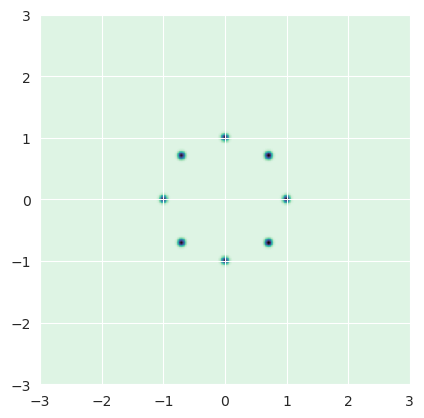

In [14]:
plot_heatmap(samples, -3, 3)

# NN approx

We implement a NN to approximate the score of the training dataset. We then sample from the reverse differential equation

In [15]:
from diffusion.embedding import SimpleTimeEmbedding
ste = SimpleTimeEmbedding()

In [16]:
from flax import nnx

class ApproximateScore(nnx.Module):
    """A simple model with multiple fully connected layers and
    some fourier features for the time variable."""

    def __init__(self, din, *, rngs: nnx.Rngs):
        n_hidden = 256
        td = 4 # we augment the time dimension with 4 features
        self.linear1 = nnx.Linear(din+td, n_hidden, rngs=rngs)
        self.linear2 = nnx.Linear(n_hidden, n_hidden, rngs=rngs)
        self.linear3 = nnx.Linear(n_hidden, n_hidden, rngs=rngs)
        self.linear4 = nnx.Linear(n_hidden, din, rngs=rngs)

    def __call__(self, x, t):
        x = jnp.atleast_2d(x)
        t = jnp.atleast_2d(t)

        # Fourier features for time
        t = ste(t)

        x = jnp.concatenate([x, t], axis=1)

        # Using nnx.Dense throughout
        x = self.linear1(x)
        x = nnx.relu(x)
        x = self.linear2(x)
        x = nnx.relu(x)
        x = self.linear3(x)
        x = nnx.relu(x)
        x = self.linear4(x)
        return x

In [17]:
import optax

rngs =  nnx.Rngs(0)
batch_size = 16

def initialize_model():
  x = jnp.zeros(2*batch_size).reshape((batch_size, 2))
  time = jnp.ones((batch_size, 1))
  #initialize the model weights
  score_model = ApproximateScore(din=2, rngs=rngs)
  score_model(x,time)
  return score_model
# Call the function to initialize the model
score_model = initialize_model()

#Initialize the optimizer
optimizer = nnx.Optimizer(score_model, optax.adam(1e-3))  # reference sharing

#opt_state = optimizer.init(params)

In [18]:
@nnx.jit
def train_step(score_model, optimizer, batch, rngs):
    """
    params: the current weights of the model
    rng: random number generator from jax
    batch: a batch of samples from the training data, representing samples from \mu_text{data}, shape (J, N)
    opt_state: the internal state of the optimizer
    model: the score function

    takes the gradient of the loss function and updates the model weights (params) using it. Returns
    the value of the loss function (for metrics), the new params and the new optimizer state
    """
    loss_fn_ = vp.get_loss_function()

    rng = rngs.params()
    loss_fn = lambda score_model: loss_fn_(score_model, batch, rng=rng)

    loss, grads = nnx.value_and_grad(loss_fn)(score_model)
    optimizer.update(grads)  # In place updates.
    return loss

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/aamerio/ipykernel_132683/273009115.py:3: SyntaxWarning: invalid escape sequence '\m'
  """


In [19]:
N_epochs = 15_000
train_size = mf.shape[0]
batch_size = train_size
# batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size
losses = []

with tqdm(total=N_epochs, desc="Training") as pbar:
    for k in range(N_epochs):
        step_rng = rngs.params()
        perms = jax.random.permutation(step_rng, train_size)
        perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
        perms = perms.reshape((steps_per_epoch, batch_size))
        for perm in perms:
            batch = mf[perm, :]
            loss = train_step(score_model, optimizer, batch, rngs)
            losses.append(loss)
        pbar.update(1)
        if (k+1) % 200 == 0:
            mean_loss = jnp.mean(jnp.array(losses))
            pbar.set_postfix({"Loss": f"{mean_loss:.4f}"}) 
            losses = []

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

In [20]:
rev = vp.reverse(score_model) # obtain reverse SDE for the learned score

In [21]:
rng = jax.random.PRNGKey(0)
nsamples=1000
samples = rev.sample(rng, nsamples, safe=True).block_until_ready() # solve the SDE to get samples of the esimated dataset distribution

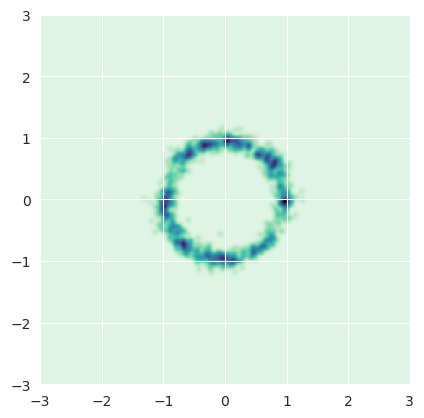

In [22]:
plot_heatmap(samples, -3, 3)